## `Setup Init`

In [1]:
import numpy as np
import pandas as pd
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

## `Importing Data` 

In [2]:
import glob

path = '../data/raw'
csv_files = glob.glob(path + "/*.csv")

df_list = (pd.read_csv(file, engine='pyarrow') for file in csv_files)

df = pd.concat(df_list, ignore_index=True)

## `Data Cleansing`

Pertama, ubah nilai yang memungkinkan sebagai missing value seperti `''` menjadi nan value:

In [11]:
cols = [
    "start_station_name", 
    "start_station_id", 
    "end_station_name", 
    "end_station_id"
]

df[cols] = df[cols].replace({'': np.nan})

Kemudian, kita lakukan penilaian awal terkait format, tipe, dan unique value pada dataset:

In [12]:
print(f'Jumlah baris dan kolom: {df.shape}')

pd.DataFrame(
    {
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value': df.isna().mean().values * 100,
    'neg_value': [True if df[col].dtype == int and (df[col] < 0).any() else False for col in df.columns],
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
    }
)

Jumlah baris dan kolom: (639424, 13)


,feature,data_type,null_value,neg_value,n_unique,sample_unique
0,ride_id,object,0.000000,False,639424,"[6842AA605EE9FBB3, F984267A75B99A8C, FF7CF57CF..."
1,rideable_type,object,0.000000,False,3,"[electric_bike, classic_bike, docked_bike]"
2,started_at,datetime64[ns],0.000000,False,594512,"[2023-03-16 08:20:34, 2023-03-04 14:07:06, 202..."
3,ended_at,datetime64[ns],0.000000,False,595322,"[2023-03-16 08:22:52, 2023-03-04 14:15:31, 202..."
4,start_station_name,object,13.778651,False,1102,"[Clark St & Armitage Ave, Public Rack - Kedzie..."
5,start_station_id,object,13.799294,False,1066,"[13146, 491, 620, TA1306000003, 18067, KA15030..."
6,end_station_name,object,14.546842,False,1120,"[Larrabee St & Webster Ave, nan, Clark St & Ra..."
7,end_station_id,object,14.568893,False,1082,"[13193, nan, TA1305000030, 13154, TA1306000015..."
8,start_lat,float64,0.000000,False,196578,"[41.91841316666667, 41.97, 41.898203, 41.88871..."
9,start_lng,float64,0.000000,False,194605,"[-87.63645116666666, -87.71, -87.637536, -87.6..."


Pola missing value antara `start_station_name` dan `start_station_id` keduanya berkorelasi kuat, artinya bisa di pastikan apabila salah satunya missing maka yang lain juga missing. Perilaku yang sama ditunjukkan antara `end_station_name` dan `end_station_id`. Adapun antara kelompok (name & id) `start` atau `end` juga saling berkorelasi, tapi lemah. Artinya bisa saja ketika kelompok `start` missing, belum tentu `end` juga missing, dan sebaliknya.

<Axes: >

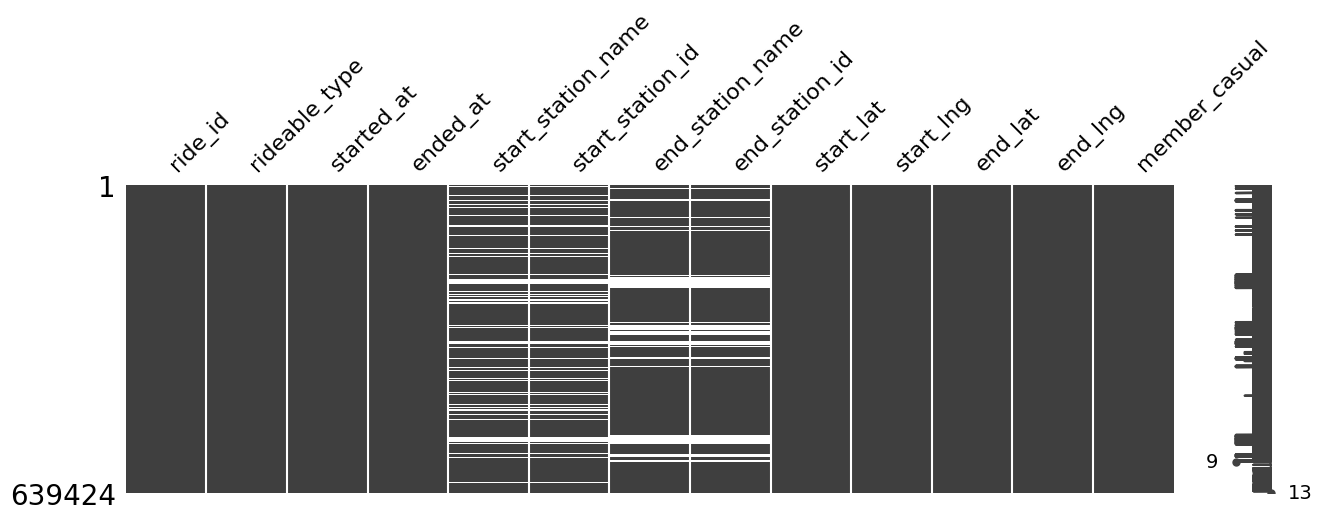

In [14]:
msno.matrix(df, figsize=(15, 4))

Kita tangani terlebih dulu missing value pada atribut `end_lat` dan `end_lng`, karena persentase keduanya hanya **0.1%**, maka kita bisa membuangnya menggunakan `dropna()`.

In [15]:
df.dropna(subset=['end_lat', 'end_lng'], axis=0, ignore_index=True, inplace=True)

Adapun pada kolom `start_station_name`, `start_station_id`, `end_station_name`, dan `end_station_id`, karena jumlahnya cukup besar yaitu **15%**, kita tangani melalui inputasi dengan value sesuai atribut latitude dan longitude yang cocok.

Pisahkan dulu antara dataframe berisi missing value (`with_nans`):

In [16]:
with_nans = df[df.isnull().any(axis=1)]
with_nans.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
567728,67983FBD388B8C64,electric_bike,2023-01-16 14:23:18,2023-01-16 14:35:00,NaN,NaN,Millennium Park,13008,41.870000,-87.620000,41.881032,-87.624084,member
434690,E09C9ED98C457CEC,electric_bike,2023-02-14 06:57:14,2023-02-14 07:11:11,NaN,NaN,Ashland Ave & Division St,13061,41.930000,-87.650000,41.903450,-87.667747,member
16165,FC37BEEB22D10EC5,electric_bike,2023-03-15 09:52:23,2023-03-15 09:56:29,Dodge Ave & Church St,600,NaN,NaN,42.048357,-87.698483,42.050000,-87.680000,casual
533365,DBE316BAFD0AFD49,electric_bike,2023-01-14 23:54:36,2023-01-15 00:00:32,Clark St & Wellington Ave,TA1307000136,NaN,NaN,41.936530,-87.647584,41.950000,-87.650000,member
215896,0C29BD49C827F74B,electric_bike,2023-03-19 11:28:22,2023-03-19 11:34:40,NaN,NaN,Clarendon Ave & Junior Ter,13389,41.970000,-87.650000,41.961004,-87.649603,member


dan dataframe tanpa missing value (`no_nans`).

In [18]:
no_nans = df[~df.isnull().any(axis=1)]
no_nans.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
490983,440A3A58F6D037C8,classic_bike,2023-01-25 17:52:26,2023-01-25 17:58:16,Larrabee St & Kingsbury St,TA1306000009,LaSalle Dr & Huron St,KP1705001026,41.897764,-87.642884,41.894877,-87.632326,member
92602,29E39588B2C298D8,classic_bike,2023-03-28 11:44:20,2023-03-28 12:05:18,Canal St & Jackson Blvd,13138,McClurg Ct & Erie St,KA1503000041,41.877245,-87.639366,41.894503,-87.617854,member
183991,C9CDCF1290C93AFE,classic_bike,2023-03-11 14:39:12,2023-03-11 14:59:03,Indiana Ave & Roosevelt Rd,SL-005,Wells St & Hubbard St,TA1307000151,41.867888,-87.623041,41.889906,-87.634266,casual
23788,CF308009C42A7834,classic_bike,2023-03-03 14:14:48,2023-03-03 14:47:37,DuSable Lake Shore Dr & Monroe St,13300,DuSable Lake Shore Dr & North Blvd,LF-005,41.880958,-87.616743,41.911722,-87.626804,casual
38495,F6CACB0557A1D18A,electric_bike,2023-03-31 06:19:32,2023-03-31 06:26:16,Desplaines St & Kinzie St,TA1306000003,St. Clair St & Erie St,13016,41.888628,-87.644400,41.894345,-87.622798,member


untuk mengisi stasiun yang sesuai, kita akan gunakan selisih jarak terkecil yang diperoleh dari formula `Haversine`.

In [19]:
def haversine(lat1, lon1, lat2, lon2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    km = 6367 * dist
    return round(km, 2) * 1000

baris dengan selisih jarak terkecil diperoleh dengan `idxmin()`.

In [20]:
def nearest(lat, long, mode='start'):
    reference = no_nans[[f'{mode}_station_name', f'{mode}_station_id', f'{mode}_lat', f'{mode}_lng']].drop_duplicates(f'{mode}_station_name')
    distances = reference.apply(
        lambda x: haversine(lat, long, x[f'{mode}_lat'], x[f'{mode}_lng']), 
        axis=1)
    return reference.loc[distances.idxmin(), [f'{mode}_station_name', f'{mode}_station_id']]

gunakan dua fungsi di atas untuk mencari nama dan id stasiun yang tepat untuk input missing value:

In [21]:
with_nans[['start_station_name', 'start_station_id']] = with_nans.apply(lambda x: nearest(x['start_lat'], x['start_lng'], 'start'), axis=1)

/var/folders/vh/81ldn_315vdf1b2_lnntkb080000gn/T/ipykernel_11246/3152822245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_nans[['start_station_name', 'start_station_id']] = with_nans.apply(lambda x: nearest(x['start_lat'], x['start_lng'], 'start'), axis=1)


In [25]:
with_nans[['end_station_name', 'end_station_id']] = with_nans.apply(lambda x: nearest(x['end_lat'], x['end_lng'], 'end'), axis=1)

merge data `with_nans` setelah inputasi dengan `no_nans`

In [32]:
df_merged = pd.concat([no_nans, with_nans], ignore_index=True, axis=0)
print(f'Jumlah baris dan kolom: {df_merged.shape}')

Jumlah baris dan kolom: (638998, 13)


terakhir, kita cek duplikat data, jika ada, data tersebut akan diambil salah satunya saja.

In [33]:
df_merged[df_merged.duplicated()]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual


## `Creating New Attributes`

Pertama kita buat atribut lain yang akan dibutuhkan dalam analisis:
* Jarak tempuh (`distance`)
* Durasi pemakaian (`duration`)
* Nama hari saat sewa (`start_day` & `ended_day`)
* Waktu start (`started_at`)
* dan waktu ended (`ended_at`)

In [36]:
df_merged = df_merged.assign(
    distance=haversine(df_merged['start_lat'], df_merged['start_lng'], df_merged['end_lat'], df_merged['end_lng']),
    duration=round(pd.to_timedelta(df_merged['ended_at'] - df_merged['started_at'], unit='seconds').dt.total_seconds() / 60, 2),
    start_day=df_merged['started_at'].dt.day_name(),
    ended_day=df_merged['ended_at'].dt.day_name(),
    start_time=df_merged['started_at'].dt.time,
    ended_time=df_merged['ended_at'].dt.time) \
.query('duration > 0 and distance > 0')

df_merged.sample(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,distance,duration,start_day,ended_day,start_time,ended_time
627809,0E832D52B6C038AB,electric_bike,2023-01-06 14:54:13,2023-01-06 14:57:21,Clifton Ave & Armitage Ave,TA1307000163,Southport Ave & Clybourn Ave,TA1309000030,41.918155,-87.657070,41.920000,-87.660000,casual,320.0,3.13,Friday,Friday,14:54:13,14:57:21
435606,1B1354D149898D4E,classic_bike,2023-01-11 15:56:51,2023-01-11 16:04:03,Paulina St & Flournoy St,KA1504000104,Ada St & Washington Blvd,13353,41.873061,-87.669135,41.882830,-87.661206,member,1270.0,7.20,Wednesday,Wednesday,15:56:51,16:04:03
476030,115F707A0E2688F8,classic_bike,2023-01-27 20:27:36,2023-01-27 20:34:56,Clark St & Bryn Mawr Ave,KA1504000151,Clark St & Leland Ave,TA1309000014,41.983593,-87.669154,41.967088,-87.667291,member,1840.0,7.33,Friday,Friday,20:27:36,20:34:56
263061,D7F2FA5B17A80288,electric_bike,2023-02-18 11:07:50,2023-02-18 11:16:04,Ritchie Ct & Banks St,KA1504000134,Halsted St & Clybourn Ave,331,41.906800,-87.626180,41.909668,-87.648128,member,1840.0,8.23,Saturday,Saturday,11:07:50,11:16:04
97929,A2523DE5FB2F8524,electric_bike,2023-03-01 07:47:31,2023-03-01 08:00:49,Morgan St & 18th St,13163,Dearborn St & Monroe St,TA1305000006,41.858047,-87.651117,41.881320,-87.629521,member,3140.0,13.30,Wednesday,Wednesday,07:47:31,08:00:49


Kemudian kita kelompokan atribut `distance` dan `duration`.

In [50]:
print(f'Distance: median {df_merged.distance.median()} - MAD {abs(df_merged.distance - df_merged.distance.median()).median()}')
print(f'Duration: median {df_merged.duration.median()} - MAD {abs(df_merged.duration - df_merged.duration.median()).median()}')

Distance: median 1380.0 - MAD 630.0
Duration: median 7.47 - MAD 3.4899999999999998


Gunakan median dan MAD sebagai dasar membagi kelompoknya.

In [46]:
def convert_duration(x):
    if x > 7.5:
        return '> 7.5 minute'
    elif x <= 12:
        return '0-7.5 minute'
    
def convert_distance(x):
    if 2100 > x > 750:
        return '750-2100 m'
    elif x <= 750:
        return '0-750 m'
    else:
        return '> 2100 m'

df_merged = df_merged.assign(
    class_duration=df_merged.duration.apply(lambda x: convert_duration(x)),
    class_distance=df_merged.distance.apply(lambda x: convert_distance(x)),
)

Dan terakhir kelompokkan `start_day` menjadi `weekend` atau `weekday`

In [51]:
def convert_day(x):
    if x in ['Friday', 'Saturday', 'Monday']:
        return 'weekend'
    else:
        return 'weekday'
    
df_merged = df_merged.assign(
    weekday=df_merged.start_day.apply(lambda x: convert_day(x))
)

## `Saving Data`

Data mentah yang sudah diolah dan siap di analisis akan kita simpan dalam folder `../data/processed`

In [48]:
df_merged.to_csv(f'../data/processed/cleaned_data.csv')